In [1]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


tf.random.set_seed(42)

data = '230802_Axial_z2_8Data'
dataname = data+'_Class_'+'01'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:13]
SensorData1 = SD1

In [2]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
195645,37,34,44,37,46,49,62,59,38.78,0,132,0,4.8
195817,38,35,46,41,44,49,60,59,37.99,0,132,0,4.8
196979,37,32,47,42,41,49,57,59,57.75,0,132,0,8.0
34923,27,33,53,45,46,51,60,62,48.76,0,22,0,7.2
109052,35,36,45,39,46,55,58,63,55.76,0,72,0,8.0


In [3]:
SDreal = SD1

In [4]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.0,235079.000000,235079.0,235079.000000
mean,37.855602,35.384769,47.421667,43.813399,45.391064,50.105960,60.760553,60.335164,28.366040,0.0,78.786263,0.0,4.397089
std,29.678911,77.255275,58.529797,71.599723,50.843784,71.695767,77.129128,50.722240,28.043329,0.0,46.194791,0.0,2.298731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,0.0,0.000000,0.0,0.800000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,11.960000,0.0,38.000000,0.0,2.400000
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,29.310000,0.0,78.000000,0.0,4.000000
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,62.000000,43.440000,0.0,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,10001.950000,0.0,158.000000,0.0,8.000000


In [5]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 80)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

SDreal = SDreal[SDreal["r"] >= 0.8*3]

Zinit = 10
Zend = 150

SDreal = SDreal[SDreal["z"] >= Zinit]
SDreal = SDreal[SDreal["z"] <= Zend]



SDreal["z"] -= Zinit
SDreal["z"] /= 2

SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,144569.000000,144569.000000,144569.000000,144569.000000,144569.000000,144569.000000,144569.000000,144569.000000,144569.000000,144569.0,144569.000000,144569.0,144569.000000
mean,37.078440,34.168107,47.043467,43.093540,44.860897,49.854346,59.917527,60.472190,38.419449,0.0,34.924949,0.0,5.600094
std,2.959642,3.187947,3.288932,3.855568,3.442767,3.721552,3.049256,3.750857,12.415146,0.0,20.492829,0.0,1.600206
min,4.000000,3.000000,17.000000,10.000000,3.000000,9.000000,4.000000,5.000000,10.870000,0.0,0.000000,0.0,3.200000
25%,35.000000,32.000000,45.000000,40.000000,43.000000,48.000000,58.000000,59.000000,28.210000,0.0,17.000000,0.0,4.000000
50%,37.000000,34.000000,47.000000,43.000000,45.000000,50.000000,60.000000,61.000000,37.810000,0.0,35.000000,0.0,5.600000
75%,39.000000,36.000000,49.000000,46.000000,47.000000,52.000000,62.000000,63.000000,48.580000,0.0,53.000000,0.0,7.200000
max,53.000000,64.000000,68.000000,68.000000,72.000000,75.000000,74.000000,75.000000,68.550000,0.0,70.000000,0.0,8.000000


In [6]:
def normalize_dataframe(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / (df[column].max() - df[column].min()) * 2
    return df


#SDreal_normalized = normalize_dataframe(SDreal)
#SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
15753,40,36,47,44,50,50,59,63,-0.910175,0,0.0,0,-1.000039
15754,40,36,47,44,50,50,59,63,-0.910175,0,0.0,0,-1.000039
15755,40,36,47,44,50,50,59,63,-0.907748,0,0.0,0,-1.000039
15756,40,36,46,44,50,50,59,63,-0.909135,0,0.0,0,-1.000039
15757,39,36,46,44,48,50,60,63,-0.909135,0,0.0,0,-1.000039
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223380,40,34,44,44,42,44,60,47,0.692807,0,70.0,0,0.999961
223381,40,34,44,44,42,44,60,47,0.691767,0,70.0,0,0.999961
223382,39,34,44,44,41,45,60,47,0.693154,0,70.0,0,0.999961
223383,39,34,44,44,41,45,64,47,0.693154,0,70.0,0,0.999961


In [7]:
SDy = SDreal.iloc[:,[10]]
SDy.describe()

,z
count,144569.000000
mean,34.924949
std,20.492829
min,0.000000
25%,17.000000
50%,35.000000
75%,53.000000
max,70.000000


In [8]:
X = SDreal.iloc[:,:8]
y = SDreal.iloc[:,[10]]

In [9]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07
15753,40,36,47,44,50,50,59,63
15754,40,36,47,44,50,50,59,63
15755,40,36,47,44,50,50,59,63
15756,40,36,46,44,50,50,59,63
15757,39,36,46,44,48,50,60,63
...,...,...,...,...,...,...,...,...
223380,40,34,44,44,42,44,60,47
223381,40,34,44,44,42,44,60,47
223382,39,34,44,44,41,45,60,47
223383,39,34,44,44,41,45,64,47


In [10]:
y.sample(5)

,z
149235,45.0
25426,3.0
92881,26.0
49434,11.0
27913,4.0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [12]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  114498 ea 79 %    X_valid:  28625 ea 19 %    X_test:  1446 ea 1 %


In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [14]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230802_Axial_z2_8Data_Class_01_SS.pkl']

In [24]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),        
    keras.layers.Dense(256, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),        
    keras.layers.Dense(256, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),        
    keras.layers.Dense(256, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),                
    keras.layers.Dense((Zend-Zinit)/2 + 1, activation="softmax")  # 출력층의 뉴런 수를 71개로 설정하고, 활성화 함수를 softmax로 설정
])

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9), metrics=["accuracy"])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 256)               2304      
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 71)                9159      
                                                                 
Total params: 241,735
Trainable params: 241,735
Non-tr

## Callback (best, early stopping, tensorboard)

In [25]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [26]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [27]:
dataname

'230802_Axial_z2_8Data_Class_01'

In [28]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/100
3579/3579 [==============================] - 8s 2ms/step - loss: 2.1605 - accuracy: 0.2786 - val_loss: 2.0313 - val_accuracy: 0.3030
Epoch 2/100
3579/3579 [==============================] - 7s 2ms/step - loss: 2.0036 - accuracy: 0.3206 - val_loss: 2.0827 - val_accuracy: 0.2917
Epoch 3/100
3579/3579 [==============================] - 7s 2ms/step - loss: 1.9973 - accuracy: 0.3260 - val_loss: 2.0754 - val_accuracy: 0.3065
Epoch 4/100
3579/3579 [==============================] - 7s 2ms/step - loss: 2.0070 - accuracy: 0.3236 - val_loss: 2.0606 - val_accuracy: 0.2998
Epoch 5/100
3579/3579 [==============================] - 8s 2ms/step - loss: 2.0076 - accuracy: 0.3263 - val_loss: 2.0462 - val_accuracy: 0.3179
Epoch 6/100
3579/3579 [==============================] - 8s 2ms/step - loss: 1.9961 - accuracy: 0.3285 - val_loss: 2.1336 - val_accuracy: 0.3053
Epoch 7/100
3579/3579 [==============================] - 9s 2ms/step - loss: 2.0043 - accuracy: 0.3285 - val_loss: 2.1313 - val_ac

In [29]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

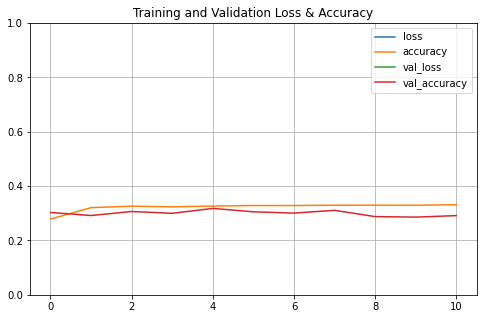

In [30]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title('Training and Validation Loss & Accuracy')
    plt.show()

plot_learning_curves(history)

In [31]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_accuracy)
print("Test loss:", test_loss)

46/46 [==============================] - 0s 1ms/step - loss: 2.0059 - accuracy: 0.3195

Test accuracy: 0.3195020854473114
Test loss: 2.0058889389038086


895/895 [==============================] - 1s 891us/step


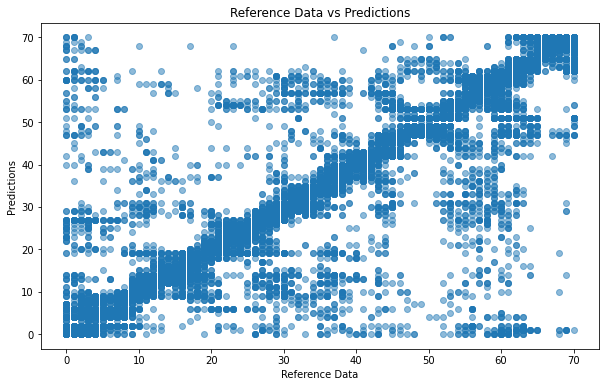

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# 모델로부터 예측값을 얻습니다.
y_pred = model.predict(X_valid)

# y_pred가 one-hot encoded 되어있다면 argmax를 사용해 class index로 변환
y_pred_class = np.argmax(y_pred, axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_class, alpha=0.5)
plt.xlabel('Reference Data')
plt.ylabel('Predictions')
plt.title('Reference Data vs Predictions')
plt.show()
